In [3]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img
from datetime import date
from datetime import datetime

# my imports
import sys
sys.path.insert(1, '../scripts')
import utils as utl
import html_evaluation_portfolio as hep
import volatility_estimator as ve
import mean_rev_utl as mru

## Importing and processing data

In [1]:
#parameters
short = 20
long = 120

USequity_list = ['SPY', 'DIA', 'QQQ', 'MDY', 'IJR', 'IWC', 'VUG',
                'VGT', 'ITOT', 'XLV', 'VNQ', 'IWD', 'XLE', 'XLF']
GLOBequity_list = ['ACWI', 'ADRE', 'SPDW', 'VEA', 'IEFA', 'DGT', 'IOO',
                'DIM', 'EFV', 'VWO', 'FM', 'SPEU', 'ASEA', 'SCZ', 'GWX']
bond_list = ['TLT', 'BND', 'TIP', 'PHB', 'BWX', 'VCSH', 'GBF', 
            'BSV', 'PLW', 'IGIB', 'IGSB', 'WIP', 'PWZ', 'CWB', 'SPTI']
commodities_list = ['DBB', 'GLD', 'SLV', 'PPLT', 'DBA', 'DBO', 'UNG', 
                   'CORN', 'SOYB', 'DBE', 'USO', 'UGA', 'GRU', 'GSG', 'FUE']
currencies_list = ['UUP', 'CYB', 'FXB', 'FXE', 'FXY', 'FXA', 'ULE', 'FXC',
              'FXF', 'DVB', 'UND','CEW', 'USDU', 'EUO', 'YCL']

list_securities = USequity_list + GLOBequity_list + bond_list + commodities_list + currencies_list
list_securities = ['SPY'] 
debug_xl = False

start_date = '2006-01-03'
end_date = "2020-11-26"

In [4]:
US_equity = pd.read_csv('../data/key_market_USequties.csv', index_col = 0, header = [0,1])
global_equity = pd.read_csv('../data/key_market_GLOBequties.csv', index_col = 0, header = [0,1])
bonds = pd.read_csv('../data/key_market_bonds.csv', index_col = 0, header = [0,1])
currencies = pd.read_csv('../data/key_market_currencies.csv', index_col = 0, header = [0,1])
commodities = pd.read_csv('../data/key_market_commodities.csv', index_col = 0, header = [0,1])
df_tot = pd.concat([US_equity, global_equity, bonds, currencies, commodities], axis = 1)
df_close = df_tot.iloc[:, df_tot.columns.get_level_values(1)=='Close']
df_close.columns = df_close.columns.droplevel(1)
data = df_close[start_date:end_date]
data = data[list_securities] 

In [66]:
#df_close[list_securities]
#list_securities = ['BND']
data = data[list_securities] 

In [5]:
#compute unique names
title = 'KAMA '
unique_name = 'KAMA'
for i in list_securities:
        unique_name += '_' + i
title += 'Currencies report'
#unique_name = unique_name + '_short_' + str(short) + '_long_'+ str(long)
#unique_name = 'KAMA_all_etfs'

### Mean average strategy

In [6]:
#main
from math import isnan

def number_nan(row):
    count = 0
    for i in range(len(row)):
        if isnan(row[i]):
            count += 1
    return len(row)-count

def create_mean_rev_signal(data, long_wind, short_wind):
    '''
    input 
    data: pandas dataframe with prices of securities (name of the column security)
    long_wind: the long window you want for the mean reverse strategy
    short_wind: the short windw you want for the mean reverse strategy
    
    output:
    final_df: pandas df filled with 1 or -1 accordingly to the mean reverse strategy
    df_rolling_mean: df with the means over the different windows for debugging
    '''
    final_df = pd.DataFrame()
    df_rolling_mean = pd.DataFrame()
    for sec in data.columns:
        sec_df = pd.DataFrame(columns = [sec])
        long_wind_df = data[sec].rolling(long_wind).mean() #creating the long window df
        df_rolling_mean[sec + '_long'] = long_wind_df #for debugging
        short_wind_df = data[sec].rolling(short_wind).mean() #creating the short window df
        df_rolling_mean[sec + '_short'] = short_wind_df #for debugging
        sec_df[sec] = (short_wind_df - long_wind_df).dropna() #subtracting the long and the short
        sec_df[sec] = sec_df[sec].apply(lambda x: 1 if x>0 else -1) #subsitute positive value with 1 and negative with a -1
        final_df[sec] = sec_df[sec]
    return final_df, df_rolling_mean

def filter_dataframe_holcv(df_tot, list_securities):
    df_output = pd.DataFrame()
    for security in list_securities:
        df_output[security + '_open'] = df_tot[security]['Open']
        df_output[security + '_high'] = df_tot[security]['High']
        df_output[security + '_low'] = df_tot[security]['Low']
        df_output[security + '_close'] = df_tot[security]['Close']
        df_output.dropna(inplace = True)
    return df_output
  
def create_kama_signal_df(data):
    '''
    input 
    data: pandas dataframe with prices of securities (name of the column security)
    
    output:
    final_df: pandas df filled with 1 or -1 accordingly to the kama strategy
    '''
    final_df = pd.DataFrame()
    df_kama = pd.DataFrame()
    for sec in data.columns:
        sec_df = pd.DataFrame(columns = [sec])
        sec_df[sec] = (ta.overlap.kama(data[sec].dropna()) - data[sec]) #subtracting the long and the short
        #sec_df[sec] = sec_df[sec].apply(lambda x: 1 if x>0 else -1) 
        final_df[sec] = sec_df[sec]
    final_df = final_df.applymap(lambda x: 1 if x>0 else -1, na_action = 'ignore') #subsitute positive value with 1 and negative with a -1
    return final_df

signal_df = create_mean_rev_signal(data, long, short)[0]

df_rolling_mean = create_mean_rev_signal(data, long, short)[1]
data_r = data.div(data.shift(1))-1 #returns of securities

### Inverse probability weighting

In [70]:
#window = 30 #days
#estimator = 'satchell'
#
#if estimator == 'satchell':
#    data_ohlc = mru.filter_dataframe_holc(df_tot, list_securities)
#    data_ohlc = data_ohlc[start_date: end_date]
#    df_satchell_volat = ve.compute_satchell_volatility(data_ohlc, list_securities, window)
#    df_satchell_volat = ve.index_df(df_satchell_volat, data, window)
#    df_satchell_inv_volat = df_satchell_volat.applymap(lambda x: 1/x)
#    df_weighted = hep.df_wheighted(df_satchell_inv_volat)
data

,UUP,CYB,FXB,FXE,FXY,FXA,ULE,FXC,FXF,DVB,UND,CEW,USDU,EUO,YCL
Date,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,109.719681,NaN,NaN,NaN,NaN,NaN,183.800003,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,110.787857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,110.550491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,NaN,NaN,NaN,111.034348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,NaN,NaN,NaN,110.404427,NaN,NaN,NaN,NaN,NaN,175.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,24.900000,25.297125,128.360001,111.669998,91.070000,72.709999,14.97,75.330002,100.230003,NaN,NaN,18.064604,25.732828,23.830000,59.410000
2020-11-20,24.930000,25.437351,128.490005,111.459999,91.019997,72.830002,14.91,75.180000,100.150002,NaN,NaN,17.975174,25.653376,23.920000,59.349998
2020-11-23,24.969999,25.325171,128.759995,111.260002,90.370003,72.610001,14.90,75.190002,99.989998,NaN,NaN,17.915556,25.762623,23.959999,58.520000


In [7]:
kama_signal_df = create_kama_signal_df(data)
kama_signal_df.index = pd.to_datetime(kama_signal_df.index)
kama_signal_df['n_sec_active'] = kama_signal_df.apply(number_nan, axis = 1)
kama_signal_df = kama_signal_df.apply(lambda row: row/row['n_sec_active'], axis = 1)
kama_signal_df.drop(columns =['n_sec_active'], inplace = True)
kama_signal_df[60:90]
print(kama_signal_df.dropna(axis=1, how='all').columns)

Index(['SPY'], dtype='object')


In [72]:
# compute data earnings
data_r.index = pd.to_datetime(data_r.index)

data_earnings = hep.df_earnings(kama_signal_df, data_r)
#data_earnings.dropna(inplace = True)
#data_earnings.index = pd.to_datetime(data_earnings.index)
data_earnings

,UUP,CYB,FXB,FXE,FXY,FXA,ULE,FXC,FXF,DVB,UND,CEW,USDU,EUO,YCL,Tot
Date,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2006-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2006-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2006-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,-0.000123,0.000592,-0.000042,-0.000173,-0.000076,0.000106,-0.000258,-0.000082,-0.000108,NaN,NaN,-0.000425,-0.000030,-0.000353,-0.000130,-0.001101
2020-11-20,0.000093,0.000426,-0.000078,0.000145,0.000042,-0.000127,0.000308,0.000153,0.000061,NaN,NaN,0.000381,-0.000238,0.000291,0.000078,0.001536
2020-11-23,0.000123,0.000339,-0.000162,0.000138,0.000549,0.000232,0.000052,-0.000010,0.000123,NaN,NaN,0.000255,0.000328,0.000129,0.001076,0.003172


In [83]:
# excel debug

if debug_xl == True:
        with pd.ExcelWriter('AW_dbg.xlsx') as writer:
            new_index = data.index.tz_convert(None)
            data.set_index(new_index).to_excel(writer, sheet_name='prices')
            new_index = data_r.index.tz_convert(None)
            data_r.set_index(new_index).to_excel(writer, sheet_name='returns')
            new_index = signal_df.index.tz_convert(None)
            signal_df.set_index(new_index).to_excel(writer, sheet_name='signals')
            new_index = df_rolling_mean.index.tz_convert(None)
            df_rolling_mean.set_index(new_index).to_excel(writer, sheet_name='rolling mean')
            new_index = data_earnings.index.tz_convert(None)
            data_earnings.set_index(new_index).to_excel(writer, sheet_name='AW_port_rets')

## Create and export plot for the report

#### Table of returns:

In [73]:
#param
figsize=(10, 5.5)
fontname = 'Arial'
annot_size=10
square = False
cbar = False
cmap = LinearSegmentedColormap.from_list('RedGreen', ['crimson', 'gold', 'lime'])
eoy = False
compounded = True

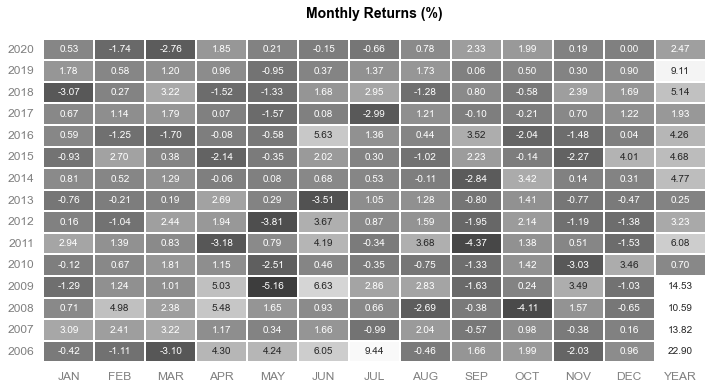

In [74]:
#crate the returns table plus the return over the year

fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)
#yearly_returns = returns.div(100).add(1).cumprod(axis=1)['DEC'] - 1
#returns['YEAR'] = yearly_returns *100
#returns

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig('../img/temp/table_montly_returns' + unique_name + '.png')
fig_table = fig 

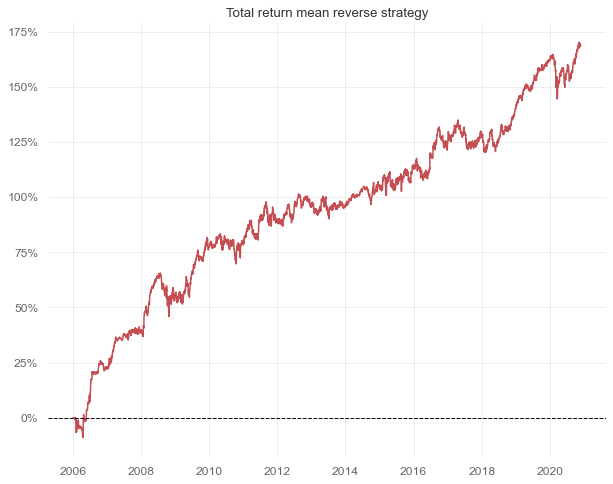

In [75]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Total return mean reverse strategy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(data_earnings['Tot']), lw=1.5, color='r', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
#ax.legend()
fig = ax.get_figure()
fig.set_size_inches(10,8)
#fig.savefig('../img/satchell_1x_leverage.png')

#### Distribution plot:

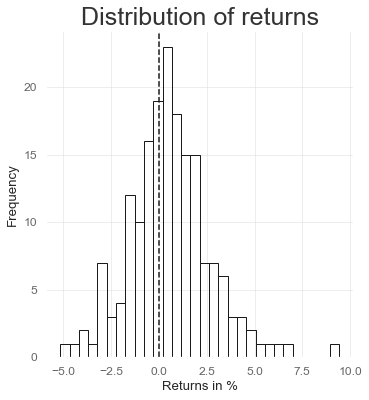

In [76]:
returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

series = pd.Series(dtype = 'float64')
for column in returns.columns:
    series = pd.concat([series,returns[column]])
#distribution(returns)
ax = series.plot.hist(bins = 30, edgecolor='k',fill=False)
ax.set_title('Distribution of returns', size = 25)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel("Returns in %")
ax.set_ylabel("Frequency")
fig = ax.get_figure()
fig.set_size_inches(5.5,6)
fig.savefig('../img/temp/distribution_returns' + unique_name + '.png')
fig_distribution = fig

#### Table of statistics:

In [77]:
# create table of stats

statistics = pd.DataFrame(columns = ['index', 'value'])

statistics.loc[0] = ['Annualised return', utl.annualized_return(data_earnings['Tot'])]
statistics.loc[1] = ['Annualised volatility', utl.annualised_volatility(data_earnings['Tot'])]
statistics.loc[2] = ['Sharpe ratio', sharpe(data_earnings['Tot'])]
statistics.loc[3] = ['Sortino ratio', sortino(data_earnings['Tot'])]
statistics.loc[4] = ['Adjusted sortino', adjusted_sortino(data_earnings['Tot'])] 
statistics.loc[5] = ['Skew', skew(data_earnings['Tot'])] 
statistics.loc[6] = ['Kurtosis', data_earnings['Tot'].kurt()] 
statistics.loc[7] = ['Max drawdown', max_drawdown(data_earnings['Tot'])] 
statistics.loc[8] = ['GPR', gain_to_pain_ratio(data_earnings['Tot'])] 
statistics.loc[9] = ['Calmar ratio', calmar(data_earnings['Tot'])] 
statistics.loc[10] = ['Pay-off ratio', payoff_ratio(data_earnings['Tot'])] 

# Annualised return (At top)
# Annualizwed volatility (At top)

#export as .csv
statistics.to_csv('../data/temp/statistics_all_weather' + unique_name + '.csv')

statistics

,index,value
0,Annualised return,0.068999
1,Annualised volatility,0.074164
2,Sharpe ratio,0.930626
3,Sortino ratio,1.425201
4,Adjusted sortino,1.007769
5,Skew,0.611149
6,Kurtosis,12.457407
7,Max drawdown,-0.119458
8,GPR,0.194784
9,Calmar ratio,0.573084


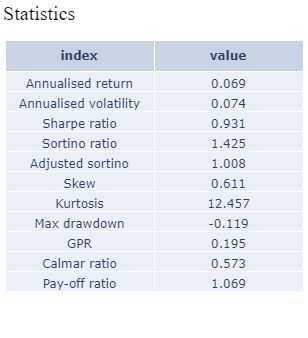

In [78]:
#transform pd. dataframe to image

fig = df2img.plot_dataframe(
    statistics.round(3),
    print_index=False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=20,
        text="Statistics"),
    fig_size=(308, 338),

   )

df2img.save_dataframe(fig=fig, filename='../img/temp/statistics_all_weather' + unique_name + '.png')

fig_stats = fig
#statistics.to_csv('./img/temp/statistics_all_weather' + unique_name + '.csv')

In [79]:
# Param
grayscale=True 
figsize= (10, 5.5)
fontname='Arial' 
lw=1
log_scale=False
match_volatility=False
compound=False
ylabel="Drawdown"
resample=None 
subtitle=True 
savefig =  '../img/temp/under_water_plot' + unique_name + '.png'
show=True

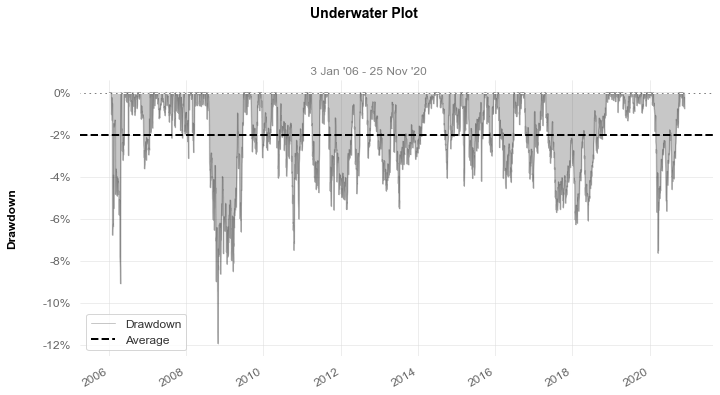

In [80]:
from quantstats._plotting.core import plot_timeseries

dd = to_drawdown_series(data_earnings['Tot'])
#bench_dd = to_drawdown_series(benchmark_portf_perc['TOT'])

fig = plot_timeseries(dd, title='Underwater Plot',
                            hline=dd.mean(), hlw=2, hllabel="Average",
                            returns_label="Drawdown",
                            compound=compound, match_volatility=match_volatility,
                            log_scale=log_scale, resample=resample,
                            fill=True, lw=lw, figsize=figsize,
                            ylabel=ylabel,
                            fontname=fontname, grayscale=grayscale,
                            subtitle=subtitle,
                            savefig=savefig, show=show)
fig

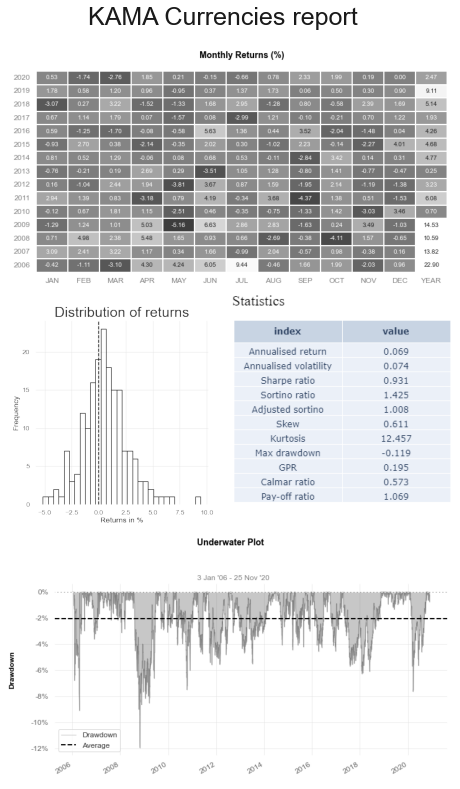

In [81]:
fig = plt.figure(figsize=(8, 13.55))
gs = gridspec.GridSpec(3, 2, wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0, :])
fig_table = plt.imread('../img/temp/table_montly_returns' + unique_name + '.png')
ax1.imshow(fig_table)
ax1.set_aspect('equal')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

ax2 = plt.subplot(gs[1,:1])
fig_distribiution = plt.imread('../img/temp/distribution_returns' + unique_name + '.png')
ax2.imshow(fig_distribiution)
ax2.set_aspect('equal')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(False)

ax3 = plt.subplot(gs[1, 1:])
fig_stats = plt.imread('../img/temp/statistics_all_weather' + unique_name + '.png')
ax3.imshow(fig_stats)
ax3.set_aspect('equal')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.grid(False)
    
ax4 = plt.subplot(gs[-1,:])
fig_underwater = plt.imread('../img/temp/under_water_plot' + unique_name + '.png')
ax4.imshow(fig_underwater)
ax4.set_aspect('equal')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid(False)

fig.suptitle(title, fontsize=25, y = 0.92, color = 'k') #add the correct leverage

plt.savefig('../reports/report_' + unique_name + '.png', dpi = 1200)

In [82]:
from math import isnan

def number_nan(row):
    count = 0
    for i in range(len(row)):
        if isnan(row[i]):
            count += 1
    return len(row)-count

data_r = data.div(data.shift(1))-1 #returns of securities
buy_and_hold_returns = data_r.copy()
buy_and_hold_returns['Tot'] = buy_and_hold_returns.sum(axis= 1)
buy_and_hold_returns.index = pd.to_datetime(buy_and_hold_returns.index)
buy_and_hold_returns['n_sec_active'] = buy_and_hold_returns.drop(columns = ['Tot']).apply(number_nan, axis = 1)
buy_and_hold_returns['Tot'] = buy_and_hold_returns['Tot']/buy_and_hold_returns['n_sec_active']
#buy_and_hold_returns.drop(columns = ['n_sec_active'], inplace = True)
buy_and_hold_returns

,UUP,CYB,FXB,FXE,FXY,FXA,ULE,FXC,FXF,DVB,UND,CEW,USDU,EUO,YCL,Tot,n_sec_active
Date,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2006-01-04,NaN,NaN,NaN,0.009736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009736,1
2006-01-05,NaN,NaN,NaN,-0.002143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002143,1
2006-01-06,NaN,NaN,NaN,0.004377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004377,1
2006-01-09,NaN,NaN,NaN,-0.005673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005673,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,-0.001604,-0.007701,0.000546,0.002244,0.000989,-0.001373,0.003351,0.001063,0.001399,NaN,NaN,0.005531,-0.000386,-0.004595,0.001686,0.000088,13
2020-11-20,0.001205,0.005543,0.001013,-0.001881,-0.000549,0.001650,-0.004008,-0.001991,-0.000798,NaN,NaN,-0.004951,-0.003088,0.003777,-0.001010,-0.000391,13
2020-11-23,0.001604,-0.004410,0.002101,-0.001794,-0.007141,-0.003021,-0.000671,0.000133,-0.001598,NaN,NaN,-0.003317,0.004259,0.001672,-0.013985,-0.002013,13


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2020-11-25  2020-11-25
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          168.29%     19.98%
CAGR﹪                     6.85%       1.23%

Sharpe                     0.93        0.24
Prob. Sharpe Ratio         99.99%      82.99%
Smart Sharpe               0.89        0.23
Sortino                    1.43        0.37
Smart Sortino              1.36        0.36
Sortino/√2                 1.01        0.26
Smart Sortino/√2           0.96        0.25
Omega                      1.19        1.19

Max Drawdown               -11.95%     -19.01%
Longest DD Days            580         3404
Volatility (ann.)          7.42%       5.65%
R^2                        0.01        0.01
Information Ratio          0.04        0.04
Calmar                     0.57        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-07-25,2008-10-27,2009-06-30,340,-11.945772,-9.465214
2,2006-01-20,2006-04-19,2006-04-24,94,-9.089941,-8.816417
3,2020-02-05,2020-03-19,2020-10-06,244,-7.634747,-7.502185
4,2010-05-03,2010-10-14,2011-01-31,273,-7.498473,-7.083060
5,2017-04-24,2018-02-01,2018-11-16,571,-6.277412,-6.022223


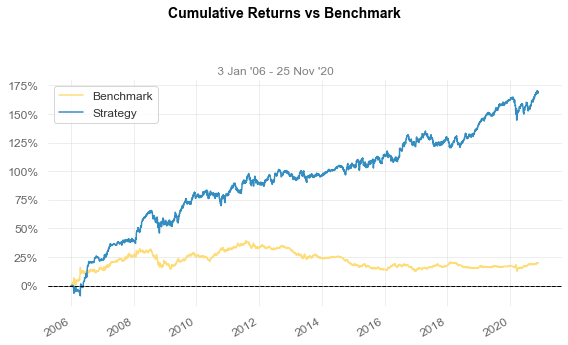

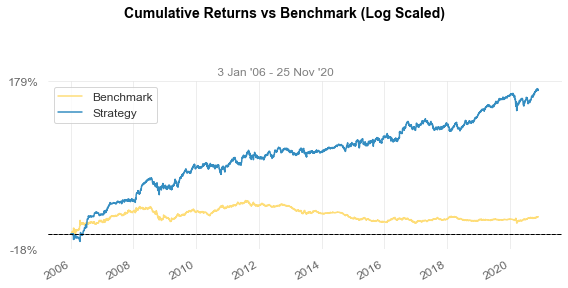

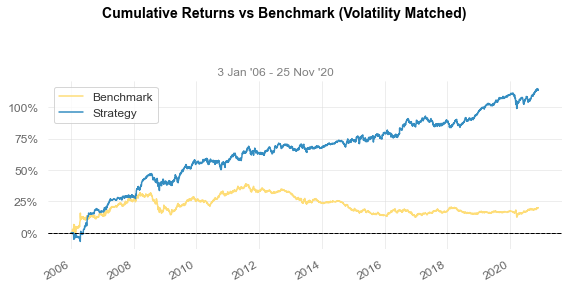

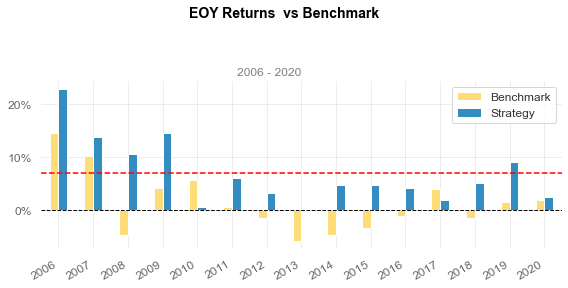

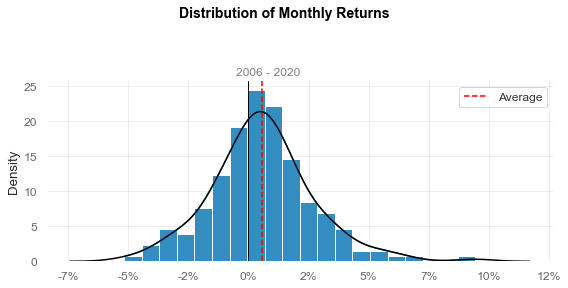

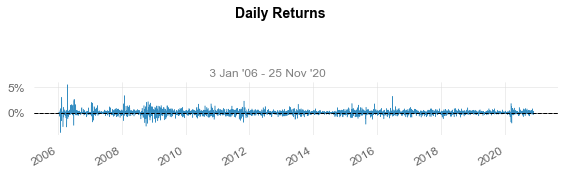

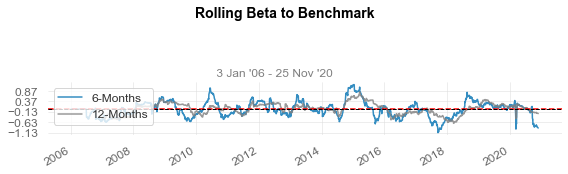

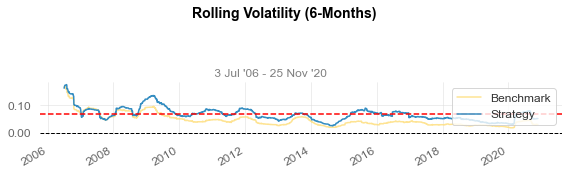

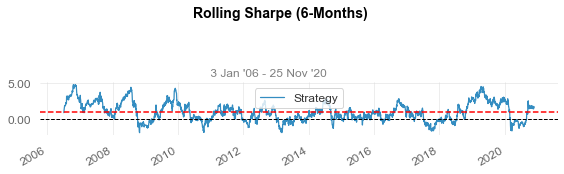

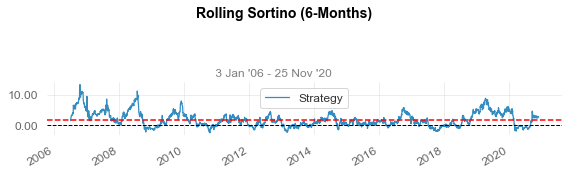

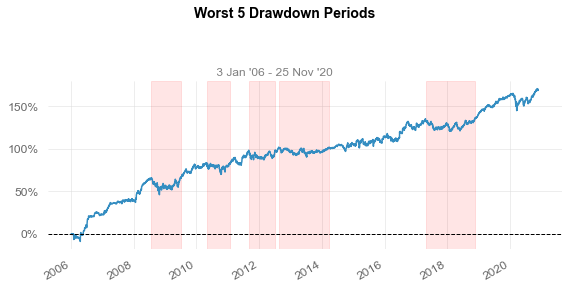

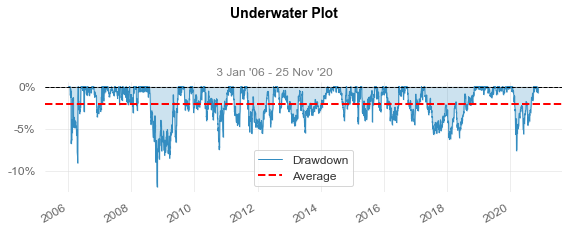

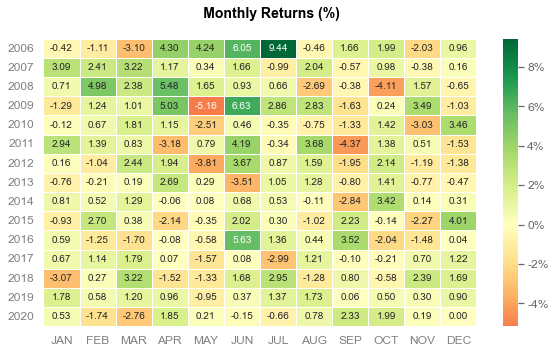

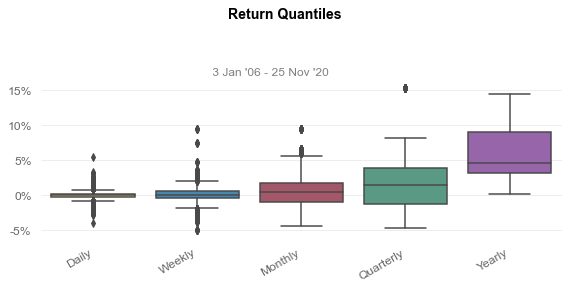

In [83]:
import quantstats as qs 

qs.reports.full(data_earnings['Tot'], benchmark = buy_and_hold_returns['Tot'])

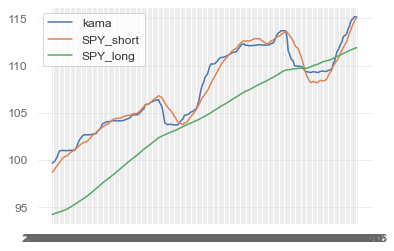

In [17]:
plt.plot(ta.overlap.kama(data['SPY'])[200:450], label = 'kama')
#plt.plot(ta.overlap.ema(data['SPY'])[200:450], label = 'ema')
plt.plot(df_rolling_mean['SPY_short'][200:450], label = 'SPY_short')
plt.plot(df_rolling_mean['SPY_long'][200:450], label = 'SPY_long')
plt.legend()
plt.show()

In [15]:
df_rolling_mean = mru.create_mean_rev_signal(data, long, short)[1]
df_rolling_mean

,SPY_long,SPY_short
Date,,
2006-01-03,NaN,NaN
2006-01-04,NaN,NaN
2006-01-05,NaN,NaN
2006-01-06,NaN,NaN
2006-01-09,NaN,NaN
...,...,...
2020-11-19,322.952782,338.003925
2020-11-20,323.324711,338.469679
2020-11-23,323.720561,339.350949
